In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

# Task: Plot Sample Images from Each Class

The following code is designed to visualize sample images from each class of historical structures. It helps in understanding the diversity and characteristics of the dataset.

* Function **load_images_from_folder**: This function reads a specified number of images from a given folder. It returns a list of loaded images.
* Function **plot_images**: This function takes a list of images and a title, creating a grid plot to display the images using Matplotlib. 

In [3]:
def load_images_from_folder(folder, num_images=10):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
        if len(images) >= num_images:
            break
    return images

def plot_images(images, title):
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(images):
        plt.subplot(3, 4, i + 1)  # Adjust grid size based on number of images
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [4]:
# Define the base path to your dataset
base_path = 'dataset_hist_structures 2 /dataset_hist_structures/Stuctures_Dataset/'

# List of classes to iterate through
classes = [
    'altar', 'apse', 'bell_tower', 'column',
    'dome(inner)', 'dome(outer)', 'flying_buttress',
    'gargoyle', 'stained_glass', 'vault'
]

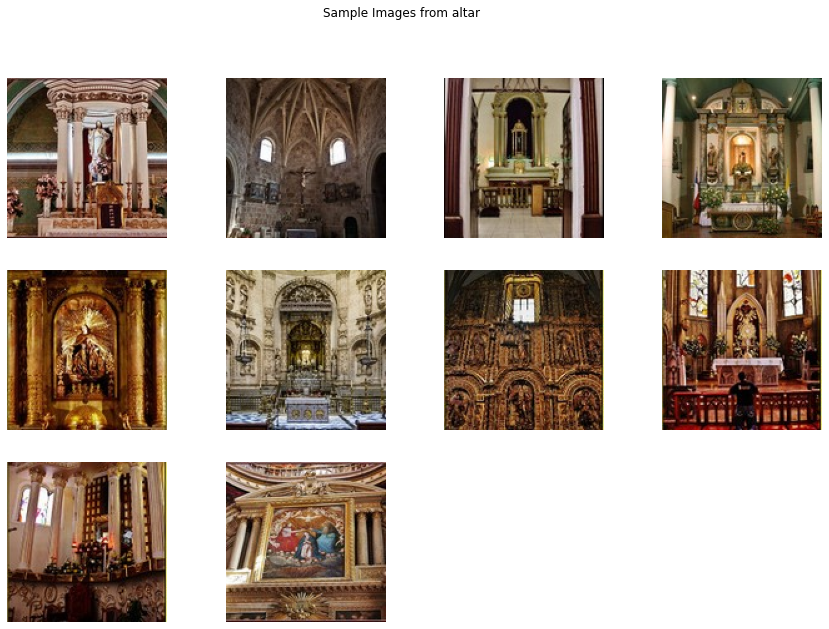

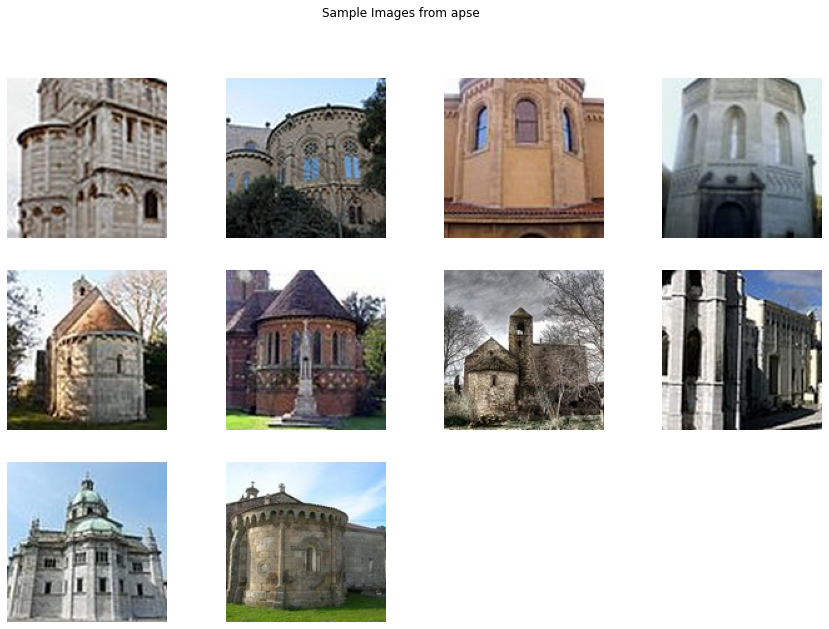

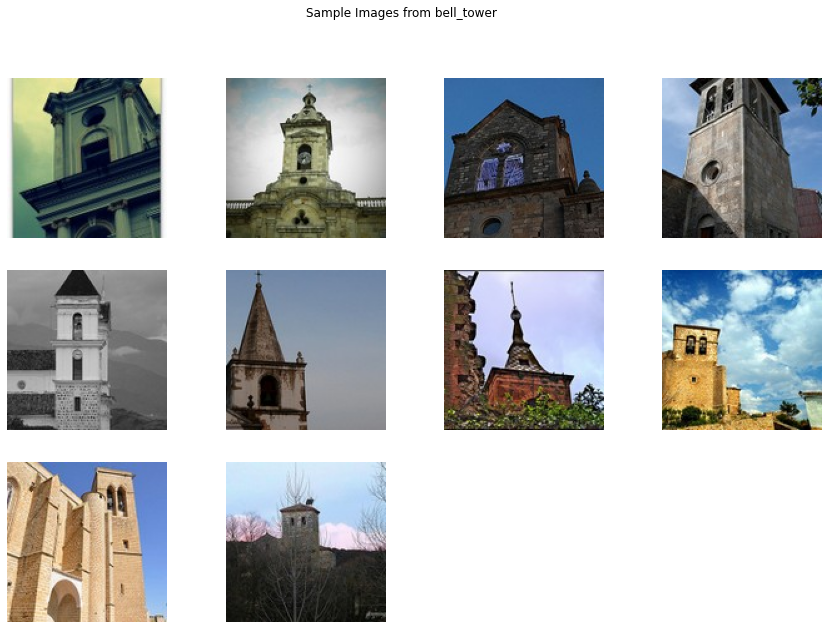

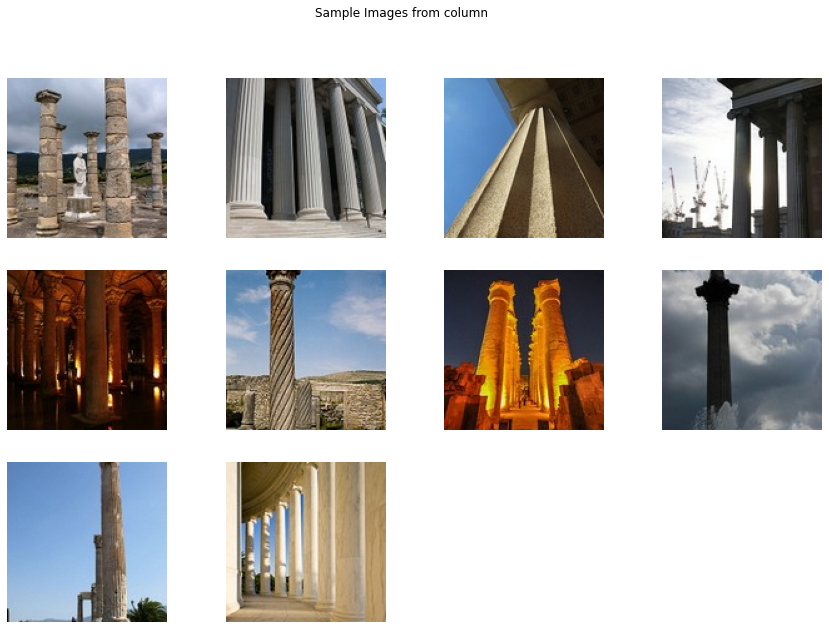

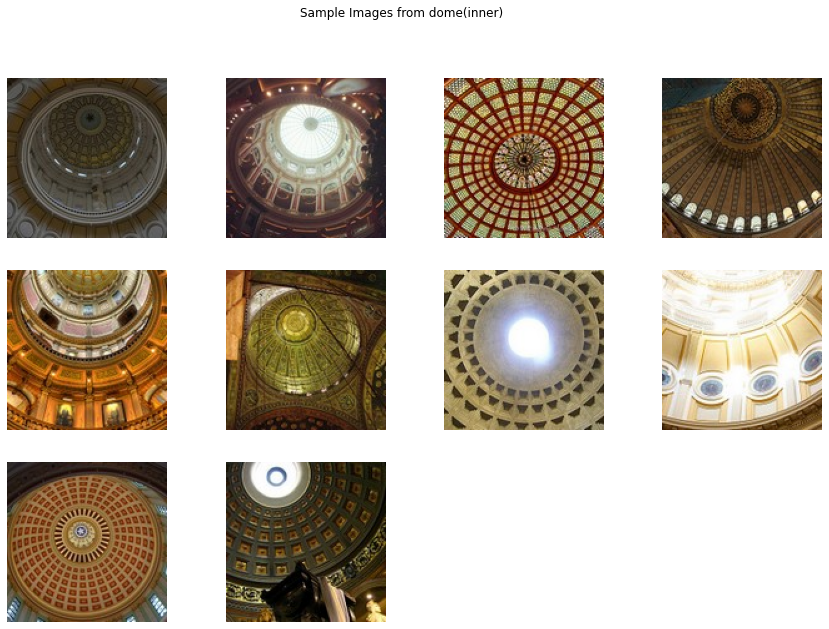

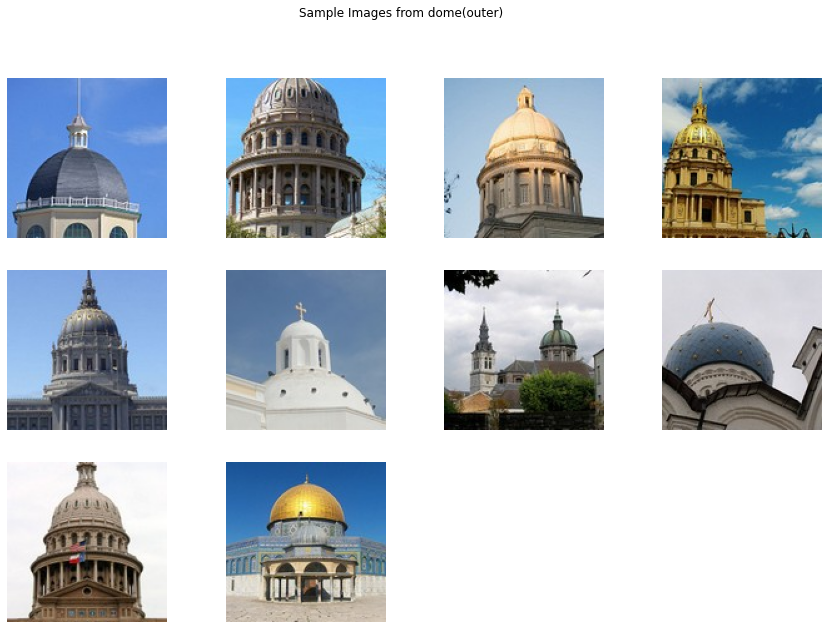

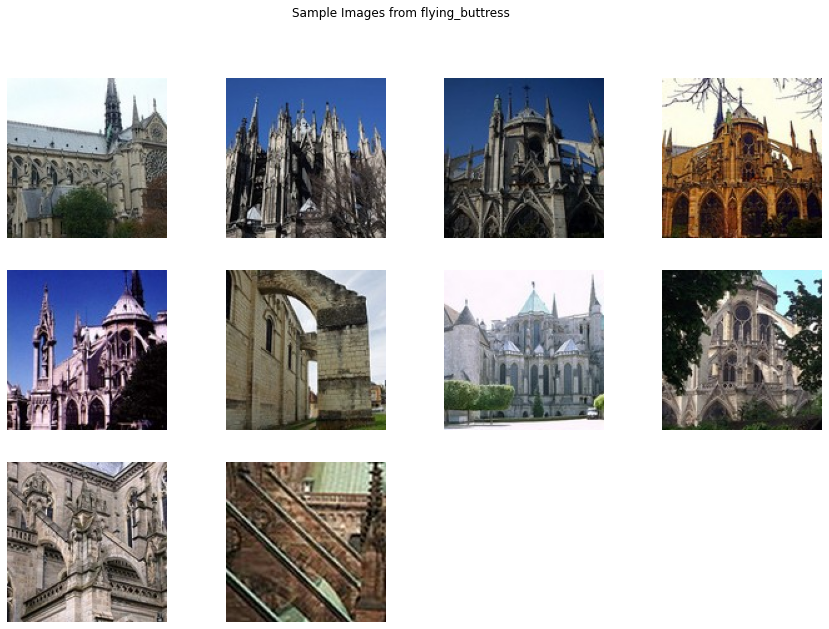

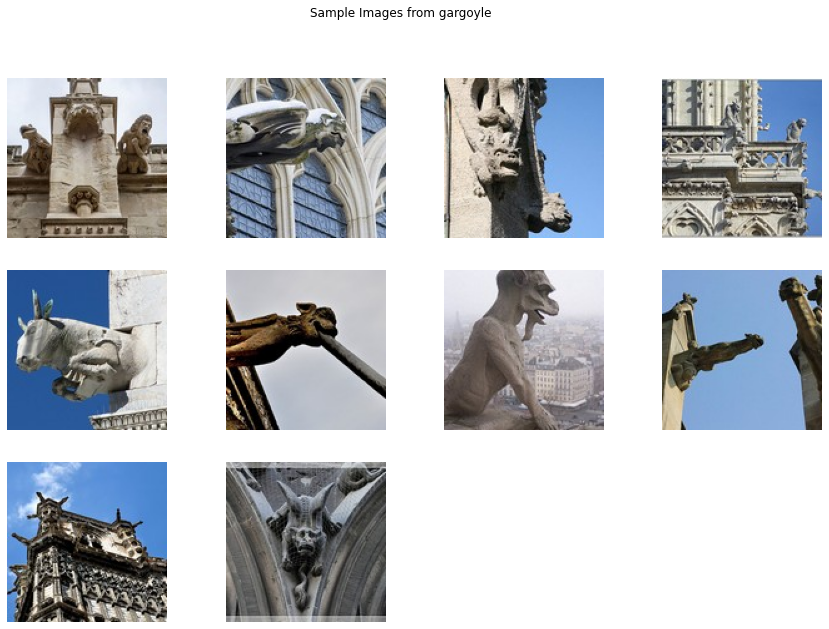

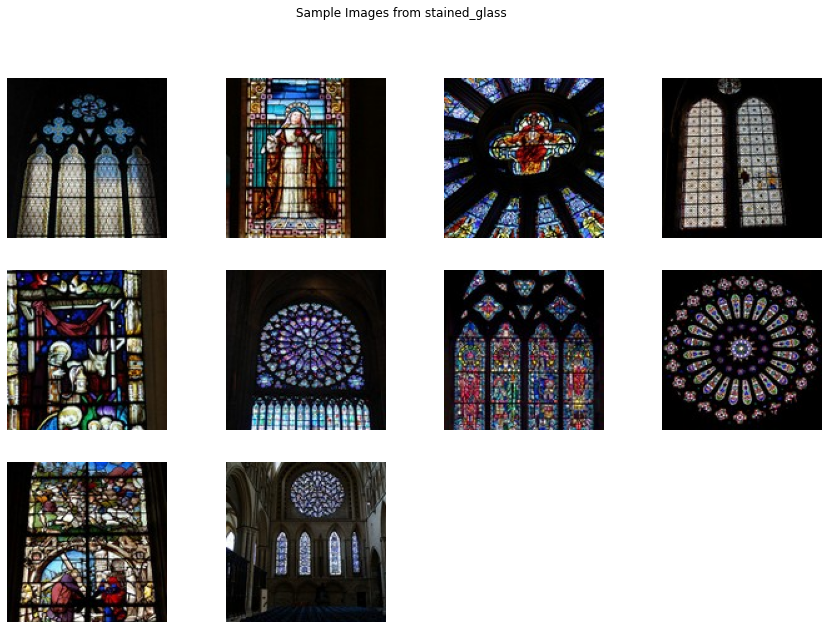

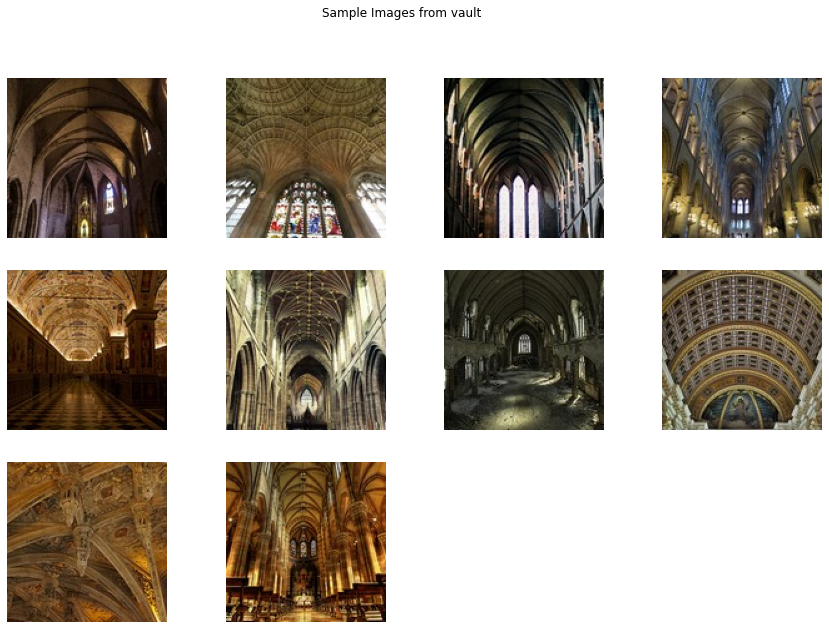

In [5]:
# Iterate through each class folder and plot images
for category in classes:
    category_path = os.path.join(base_path, category)
    if os.path.isdir(category_path):
        sample_images = load_images_from_folder(category_path)
        plot_images(sample_images, title=f'Sample Images from {category}')

# Task: Select a CNN Architecture for Transfer Learning and implement Transfer Learning Techniques
For historical structure classification, EfficientNet is a strong candidate:

* It achieves a good balance between accuracy and computational efficiency.
* It comes with pre-trained weights from ImageNet, ideal for transfer learning.

In [6]:
# Define the number of classes based on the dataset
num_classes = 11

# Load the EfficientNetB0 model with pre-trained weights from ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Task: Modify CNN Architecture with Dense Layers and Dropout

In [6]:
# Create a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # Dense layer with ReLU activation
    layers.Dropout(0.5),                   # Dropout for regularization
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

# Task: Compile the Model

In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
# Summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 4214958 (16.08 MB)
Trainable params: 16538

* **Purpose**: The above block of code sets up a convolutional neural network (CNN) using transfer learning with EfficientNetB0 as the backbone architecture.
* **EfficientNetB0**: Chosen for its efficiency and performance in image classification tasks. It is initialized with weights pre-trained on ImageNet.
* **Model Configuration**: The top layers are modified to adapt to our specific classification task by adding dense layers and dropout for regularization.
* **Compilation**: The model is compiled with Adam optimizer and sparse categorical cross-entropy loss function suitable for multi-class classification. Adam optimizer is chosen for its adaptive learning rate capabilities.
* **Transfer Learning**: This technique allows us to leverage knowledge from large datasets (like ImageNet) to improve performance on our smaller dataset. By freezing the convolutional layers during initial training phases, we ensure that learned features remain intact while fine-tuning the top layers.

Some additional dense layers and dropout were added.
* **Dense Layers**: We used 128 layers which allows the model to learn complex representations.
* **Dropout Layer**: This layer helps prevent overfitting by randomly setting a fraction (50% here) of input units to zero during training.

# Define Callback Class for Early Stopping

In [13]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

The early stopping callback monitors validation accuracy during training. If no improvement is seen after a specified number of epochs (patience), training will stop early to prevent overfitting.

**Parameters**:
* **monitor**: The metric to monitor (validation accuracy).
* **patience**: Number of epochs with no improvement after which training will be stopped.
* **restore_best_weights**: Ensures that the model weights from the best epoch are restored after training.

# Task : Setup Dataset Directories and Review Samples

The image_dataset_from_directory function loads images organized by class into TensorFlow datasets.

In [9]:
# Define the base path to your dataset
base_path = 'dataset_hist_structures 2 /dataset_hist_structures/Stuctures_Dataset/'

# Load the entire dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

# Get class names and number of classes
class_names = dataset.class_names
print(f'Classes: {class_names}')

Found 10543 files belonging to 11 classes.
Classes: ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'portal', 'stained_glass', 'vault']


 The dataset is split into training (80%) and validation sets (20%) programmatically since no separate validation set exists.

In [10]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size   # 20% for validation

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Review the number of samples in each class
print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

Train samples: 264
Validation samples: 66


# Task: Train Model Without Augmentation

The model is trained using the training dataset while monitoring its performance on the validation dataset. The number of epochs can be adjusted based on convergence behavior observed during training.

In [12]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
264/264 [==============================] - 612s 2s/step - loss: 0.4052 - accuracy: 0.8784 - val_loss: 0.1449 - val_accuracy: 0.9556
Epoch 2/20
264/264 [==============================] - 473s 2s/step - loss: 0.1690 - accuracy: 0.9485 - val_loss: 0.1302 - val_accuracy: 0.9613
Epoch 3/20
264/264 [==============================] - 476s 2s/step - loss: 0.1299 - accuracy: 0.9614 - val_loss: 0.1079 - val_accuracy: 0.9647
Epoch 4/20
264/264 [==============================] - 472s 2s/step - loss: 0.1094 - accuracy: 0.9660 - val_loss: 0.1060 - val_accuracy: 0.9675
Epoch 5/20
264/264 [==============================] - 497s 2s/step - loss: 0.0960 - accuracy: 0.9705 - val_loss: 0.1049 - val_accuracy: 0.9685
Epoch 6/20
264/264 [==============================] - 517s 2s/step - loss: 0.0841 - accuracy: 0.9730 - val_loss: 0.1103 - val_accuracy: 0.9661
Epoch 7/20
264/264 [==============================] - 570s 2s/step - loss: 0.0727 - accuracy: 0.9762 - val_loss: 0.1123 - val_accuracy: 0.9647

# Task : Train Model With Augmentation
The augmented dataset is used for training while maintaining monitoring through callbacks.

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

train_dataset_augmented = train_dataset.map(lambda x, y: (data_augmentation(x), y))

history_augmented = model.fit(
    train_dataset_augmented,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
264/264 [==============================] - 449s 2s/step - loss: 0.4496 - accuracy: 0.8652 - val_loss: 0.1433 - val_accuracy: 0.9594
Epoch 2/20
264/264 [==============================] - 426s 2s/step - loss: 0.2853 - accuracy: 0.9089 - val_loss: 0.1203 - val_accuracy: 0.9628
Epoch 3/20
264/264 [==============================] - 430s 2s/step - loss: 0.2699 - accuracy: 0.9164 - val_loss: 0.1426 - val_accuracy: 0.9594
Epoch 4/20
264/264 [==============================] - 430s 2s/step - loss: 0.2326 - accuracy: 0.9201 - val_loss: 0.1247 - val_accuracy: 0.9642
Epoch 5/20
264/264 [==============================] - 431s 2s/step - loss: 0.2185 - accuracy: 0.9258 - val_loss: 0.1195 - val_accuracy: 0.9675
Epoch 6/20
264/264 [==============================] - 436s 2s/step - loss: 0.2058 - accuracy: 0.9292 - val_loss: 0.1240 - val_accuracy: 0.9647
Epoch 7/20
264/264 [==============================] - 429s 2s/step - loss: 0.2065 - accuracy: 0.9316 - val_loss: 0.1289 - val_accuracy: 0.9675

# Task : Visualize Training and Validation Accuracy

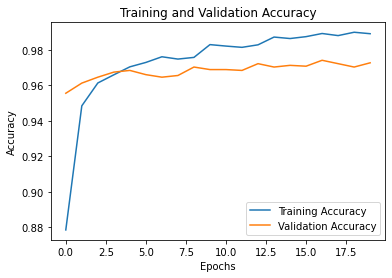

In [14]:
#Plot of Training and Validation Accuracy before model has been trained with augmentation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Observations:
* The close tracking of validation to training accuracy suggests good generalization
* No significant overfitting as the gap between curves remains relatively small
* Model appears to have reached convergence by the end of training
* The learning process appears stable and well-behaved
* Training could potentially be stopped earlier (around epoch 10) as improvements after this point are minimal
* The model shows rapid improvement in early epochs (0-2.5)
* Training accuracy reaches approximately 0.98 (98%)
* Validation accuracy plateaus around 0.97 (97%)

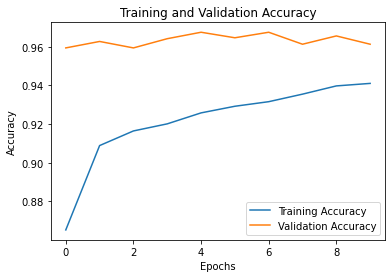

In [15]:
#Plot of Training and Validation Accuracy after model has been trained with augmentation
plt.plot(history_augmented.history['accuracy'], label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Observations:

**Training Accuracy**:

* The training accuracy starts low but steadily increases over the epochs.
* The curve is smooth, indicating that the model is learning consistently during training.

**Validation Accuracy**:

* The validation accuracy also increases over the epochs but shows more fluctuations compared to the training accuracy.
* The validation accuracy curve is consistently higher than the training accuracy curve, which may indicate that the data augmentation has helped improve generalization.

**Performance Trends**:

* Both training and validation accuracy improve over time, suggesting that the model is learning effectively.
* The fluctuations in validation accuracy could be due to the variability introduced by data augmentation or the validation dataset's inherent complexity.

**Potential Overfitting**:

* There is no clear sign of overfitting since the validation accuracy does not drop significantly or diverge from the training accuracy.
* The gap between training and validation accuracy is minimal, which is a positive indicator of the model's generalization ability.

---------------------------------------